# Introduction

This notebook allows you to run a simplified version of the ANTARESS workflow, for the following purpose:
- extracting from a CCF dataset the stellar lines occulted by a transiting planet
- performing a Rossiter-McLaughlin Revolutions analysis of the dataset

The default version of this notebook is set up to process a mock dataset generated with ANTARESS (see `ANTARESS_nbook_mock.ipynb`). To try it out, copy the directory `Valinor_Saved_data` from `Notebooks/Mock_system/` into the directory of your choice (named, for example, `Working_dir/`). Otherwise simply modify the settings to analyze a series of measured CCF fits files. Set `working_path` to the directory where you stored your copy of the `Valinor_Saved_data` directory, or where you would like your RMR analysis of an observed dataset to be stored.

To exploit the workflow to its full capabilities, run its executable with the [configuration files](https://obswww.unige.ch/~bourriev/antaress/doc/html/installation.html).

In [1]:
import ANTARESS_nbook_bground
input_nbook = ANTARESS_nbook_bground.init('RMR')
input_nbook['working_path'] = '/Users/bourrier/Travaux/ANTARESS/Working_dir/'

# System parameters

**Parameters of the host star**

Run this cell to define the host star. 
- `star_name` (string): Name of the star. Should not contain spaces/dashes.
- `Rs` (float): Radius of the star, in $R_\odot$.
- `vsini` (float): Projected stellar surface velocity, in km/s. The value given here is only used as guess for the fits, as it will eventually be derived from your analysis.
- `ld_u1` (float): First coefficient of the quadratic limb-darkening.
- `ld_u2` (float): Second coefficient of the quadratic limb-darkening.

In [2]:
input_nbook['par'].update({
    'star_name' : 'Arda',
    'Rs'        : 0.9,
    'vsini'     : 3.,
    'ld_u1'     : 0.2,
    'ld_u2'     : 0.5
})
ANTARESS_nbook_bground.init_star(input_nbook)

**Parameters of transiting planet**

Run this cell to set the transiting planet on which the RM analysis is applied. 
- `planet_name` (string): Name of the transiting planet. Should not contain spaces/dashes.
- `period` (float): Orbital period, in days.
- `T0` (float): Mid-transit time, in ${\rm BJD}_{\rm TBD}$.
- `ecc` (float): Orbital eccentricity.
- `long_per` (float): Longitude of periastron, in degrees. If the orbit is circular, fill in `90.`.
- `Kstar` (float): RV semi-amplitude, in m/s.
- `aRs` (float): Scaled separation $a/R_\star$.
- `incl` (float): Orbital inclination, in degrees.
- `RpRs` (float): Planet-to-star radius ratio $R_{\rm p}/R_\star$.

In [3]:
input_nbook['par'].update({
    'planet_name' : 'Valinor',
    'period'      : 3.8,
    'T0'          : 2457176.1,
    'ecc'         : 0.,
    'long_per'    : 90.,
    'Kstar'       : 38.1,
    'aRs'         : 12.0,
    'incl'        : 89.,
    'RpRs'        : 0.1
})
ANTARESS_nbook_bground.init_pl(input_nbook,'main')

**Parameters of additional planets in the system**

Run this cell to set additional planets, which will only contribute to the computation of the star Keplerian motion. 

The names and definitions of the parameters are the same as for the main planet (`aRs`, `incl`, `RpRs` are not required).

Copy the cell to add further planets

In [4]:
input_nbook['par'].update({
    'planet_name' : 'Numenor',
    'period'      : 8.,
    'T0'          : 2457176.2,
    'ecc'         : 0.,
    'long_per'    : 90.,
    'Kstar'       : 20.
})
ANTARESS_nbook_bground.init_pl(input_nbook,'sec')

# Dataset properties

**Visit**

Run this cell to define the visit to be processed. It must overlap with the transit of the `transiting planet`.
- `instrument` (string): Instrument of the visit (e.g. `ESPRESSO`, `NIRPS_HE`...).
- `night` (string): Night of the visit. It is preferred to use the standard format, i.e. `YYYYMMDD`.
- `data_dir` (string): Path to the directory holding the observed .fits file (here, set to `mock` to retrieve the example dataset pre-generated with ANTARESS and stored in `Valinor_Saved_data/`)

In [5]:
input_nbook['par'].update({
    'instrument'  : 'ESPRESSO',
    'night'       : '20230624',
    'data_dir'    : 'mock' 
})
ANTARESS_nbook_bground.add_vis(input_nbook)

**Systemic velocity**

Run this cell to set the systemic radial velocity `gamma` (float, in km/s).

Run the notebook a first time with `gamma` = 0 km/s to determine the value specific to your chosen visit (`gamma` can vary slightly with the epoch and the instrument, and should thus be derived from the dataset itself rather than set to an external value). Go directly to the `Running ANTARESS` section and read the value of `gamma` printed in the log.

Then, set `gamma` to the derived value and proceed with the analysis.

In [6]:
input_nbook['par']['gamma'] = 10.   
ANTARESS_nbook_bground.set_sysvel(input_nbook)

# Processing

**Alignment in star rest frame**

Run this cell to align the disk-integrated CCFs in the star rest frame. 

CCFs are originally defined in the Sun barycentric rest frame. This module shifts them by the systemic rv you defined above, and by the Keplerian rv motion induced by the planets you set up for this system.

In [7]:
ANTARESS_nbook_bground.align_prof(input_nbook)

**Flux scaling**

Run this cell to scale the disk-integrated CCFs to their correct relative flux level over the transit. 

The scaling depends on the limb-darkening coefficients and planet-to-star radius ratio you entered in the `System parameters`.

In [8]:
ANTARESS_nbook_bground.flux_sc(input_nbook)
ANTARESS_nbook_bground.DImast_weight(input_nbook)

**Differential CCFs**

Run this cell to extract differential CCFs, which are the difference between the master out-of-transit CCF (representative of the unocculted star) and the CCF in each exposure. During transit, the differential CCFs correspond to the light coming from the planet-occulted region of the stellar photosphere. 

In [9]:
ANTARESS_nbook_bground.extract_diff(input_nbook)

**Intrinsic CCFs**

Run this cell to convert in-transit differential CCFs into intrinsic CCFs, which are corrected for the planetary occultation and only trace variations in the spectral profile of the stellar line along the transit chord.

The intrinsic CCF series associated with your transiting `planet` can be retrieved under `/Working_dir/planet_Saved_data/Intr_data/instrument_night_i.npz`, where `i` refers to in-transit indexes.  

In [10]:
ANTARESS_nbook_bground.extract_intr(input_nbook)

# Analysis and plot display

Results from the fits you are going to perform are printed in the log of Section 6 below. For each fitted parameter, the workflow indicates its median and the 1-$\sigma$ errors and associated intervals from the Highest Density Intervals (when a MCMC has been used).

**Analysis of disk-integrated CCFs**

Run this cell to perform a Gaussian fit to each disk-integrated CCF. This will return the rv, FWHM, and contrast time-series of the average line from the entire stellar disk, which you can visualize below. This step is used to measure the systemic rv, to check that your Keplerian model matches the data, and to search for systematic trends in the line properties. 

Additional model and fit options are available through the configuration file. The full workflow will also allow you to correct for putative line trends.

In [11]:
ANTARESS_nbook_bground.ana_prof(input_nbook,'DI')

**Plotting disk-integrated CCFs**

Run this cell to plot the disk-integrated CCF series with their best fits. Uncomment `y_range` to adjust the flux range of the CCFs (vertical axis).

In [12]:
input_nbook['par']['y_range'] = [2.1e5,3.6e5] 
ANTARESS_nbook_bground.plot_prof(input_nbook,'DI_prof')

**Plotting disk-integrated line properties**

Run this cell to plot the time-series of properties derived from the fits to disk-integrated CCFs. 

In [13]:
ANTARESS_nbook_bground.plot_prop(input_nbook,'DI')

**Analysis of intrinsic CCFs**

Run this cell to perform a Gaussian fit to each intrinsic CCF. This will return the rv, FWHM, and contrast time-series of the average stellar line from regions occulted along the transit chord, which you can visualize below. 

Intrinsic CCFs are usually measured with low S/N. In that case, you can run the fits using a MCMC (`fit_mode = "MCMC"`) rather than the default least-square minimization (`fit_mode = "chi2"`). To overwrite the default priors, you can further uncomment the `priors` field and define the lower and upper boundary of the uniform prior ranges. Look at the time-series of properties plotted below to adjust the priors, or at the MCMC chains and corner plots in the directories `/Working_dir/planet_Saved_data/Introrig_prop/instrument_night_mcmc/iexp*/`. Since running the MCMC may take some time, you can set `calc_fit` to `False` once the MCMC is done and you only want to manipulate the plots.

This step is used to identify which exposures should be included in the RM Revolutions fit, by assessing the quality of intrinsic CCFs. The derived stellar line properties can further be analyzed in the next step. Additional stellar line models and fit options are available through the configuration file. 

In [14]:
#Uncomment to use the MCMC
input_nbook['par']['fit_mode'] = 'mcmc'

#Uncomment to set your own priors
input_nbook['par']['priors']={        
    'rv':{'low':-5.,'high':5.},    
    'FWHM':{'low':0.,'high':8.},
    'ctrst':{'low':0.,'high':1.}}

#Set to True to run the fit, and to False to retrieve its results
input_nbook['par']['calc_fit'] = False

ANTARESS_nbook_bground.ana_prof(input_nbook,'Intr')

**Plotting intrinsic CCFs**

Run this cell to plot the intrinsic CCF series with their best fits. Uncomment `y_range` to adjust the flux range of the CCFs (vertical axis). 

In [15]:
input_nbook['par']['y_range'] = [0.2,1.5] 
ANTARESS_nbook_bground.plot_prof(input_nbook,'Intr_prof')

**Analysis of intrinsic properties**

Run this cell to fit the series of rv, contrast, and FWHM derived from the fits to individual intrinsic CCFs. This step is used to determine the best models describing variations of these properties along the transit chord, which will then be used in the global Rossiter-McLaughlin Revolutions fit. Guess values for the global fit can be informed by the results of this step, printed in the log below.

The models are controlled by various parameters `x`, for which you must define a range [${\rm x}_{\rm low}$,${\rm x}_{\rm high}$] in the `mod_prop` dictionary. If you run a least-square fit, it will be initialized with the mean of this range. If you run a MCMC fit, its walkers will be initialized over this range. If the data allows it you can increase the complexity of the models by uncommenting additional parameters, as described below.

- The intrinsic rv series traces the motion of the stellar surface along the transit chord, and thus depend on the sky-projected angle `lambda` (in degrees) between the stellar spin and orbital normal, and on the sky-projected stellar rotational velocity `veq` (in km/s). Here we are assuming solid-body rotation for the star, so that the stellar inclination is degenerate and fixed to 90$^{\circ}$. The rv model can be modulated by stellar differential rotation, in which case you can break this degeneracy and fit for `istar` (in degrees) and the coefficient `alpha` (0 corresponds to solid rotation, 1 to the poles not rotating). The rv model can further be modulated by convective blueshift, defined as a polynomial of the center-to-limb angle for which you can control the linear or quadratic coefficients `c1_CB` and `c2_CB`.

- The intrinsic contrast and FWHM series trace the shape of the planet-occulted stellar lines along the transit chord. They are modelled as polynomials of the center-to-limb angle for which you can control the coefficients `x_i`, with `i`$\ge0$. 

Depending on the number of parameters and the dataset, you may need to adjust the number of walkers in the MCMC, their steps, and the burn-in phase by uncommenting the `mcmc_set` dictionary. Check the MCMC chains in `/Working_dir/planet_Saved_data/Joined_fits/IntrProp/mcmc/x/` to adjust these numbers. As with the fits to intrinsic CCFs you can overwrite the default MCMC priors for any of the fitted parameters. Once you have run the fit, you can set `calc_fit` to `False` to manipulate the plots. 

You can fit all in-transit exposures by setting `idx_in_fit` to `all`. However the occulted stellar lines and their derived properties may be so noisy in some exposures, especially at the stellar limbs, that they do not bring any constraint to the fits. It also happens that the planet only occults the star for a small fraction of the ingress/egress exposure, as in the example mock dataset, so that the model planet does not transit. In that case, you can change `idx_in_fit` to the list of indexes indicating which exposures to fit (indexes are counted from 0 from the first in-transit exposure). 

If the star is too faint or the planet too small, the properties may all be derived with a precision that is too low to analyze them here. In that case, you can apply directly the Revolutions fit with the simplest models to describe these properties. 

Finally, in this notebook we are using a simple Gaussian profile to fit the intrinsic lines. Although this model includes instrumental convolution, it is an approximation compared to using ANTARESS numerical stellar grid to simulate realistic line profiles, as is done when applying the RM Revolutions fit. Here we do not account in particular for the blurring induced by the planet motion, which is significant for long exposure times and fast-rotators. Use the configuration file if you want to fit more finely individual intrinsic profiles. 

In [16]:
#Exposures to be fitted
input_nbook['par']['idx_in_fit'] = range(1,20)

#Uncomment to use the MCMC
input_nbook['par']['fit_mode'] = 'mcmc'

#Uncomment to adjust the MCMC chains (default nwalkers = 50, nsteps = 1000, nburn = 200)
#input_nbook['par']['mcmc_set']={'nwalkers':10,'nsteps':100,'nburn':0} 

#Surface RV: main parameters
input_nbook['par']['mod_prop']={ 
    'veq':[0.,10.],
    'lambda':[-180.,180.]    
}

#Surface RV: convective blueshift
#input_nbook['par']['mod_prop']['c1_CB']=[-1.,1.] 
#input_nbook['par']['mod_prop']['c2_CB']=[-1.,1.]

#Surface RV: differential rotation
#input_nbook['par']['mod_prop']['alpha']=[0.,0.2] 
#input_nbook['par']['mod_prop']['istar']=[-90.,90.]

#Intrinsic line contrast and FWHM: polynomial coefficients
input_nbook['par']['mod_prop']['contrast_0']=[0.2,0.9]   
#input_nbook['par']['mod_prop']['contrast_1']=[-1.,1.]   
input_nbook['par']['mod_prop']['FWHM_0']=[2.,10.]   
#input_nbook['par']['mod_prop']['FWHM_1']=[-5.,5.]

#Uncomment to set your own priors
input_nbook['par']['priors']={        
    'veq':{'low':0.,'high':10.},  
    'lambda':{'low':-180.,'high':180.},  
    'contrast_0':{'low':0.,'high':1.},    
    'FWHM_0':{'low':0.,'high':20.}}

#Set to True to run the fit, and to False to retrieve its results
input_nbook['par']['calc_fit'] = False

ANTARESS_nbook_bground.ana_jointprop(input_nbook,'Intr')

**Plotting intrinsic properties**

Run this cell to plot the intrinsic CCF properties and their best-fit models.

In [17]:
ANTARESS_nbook_bground.plot_prop(input_nbook,'Intr')

**Rossiter-McLaughlin Revolutions**

Run this cell to perform a RM Revolution fit to your dataset. A joint model for the occulted line profiles along the transit chord will be fitted to the exposures that you can select with `idx_in_fit`, based on your analysis from the previous step.

The model is controlled by the same parameters as for individual intrinsic properties, so that you can define the model here in the same way using the parameters that you identified as relevant in the previous step.

It is advised to run the fit through a MCMC, which you can set up after a preliminary run by checking the MCMC chains in `/Working_dir/planet_Saved_data/Joined_fits/IntrProf/mcmc/`.

Best-fit values and associated uncertainties can be read in the log below, or retrieved with additional information in the file `/Working_dir/planet_Saved_data/Joined_fits/IntrProf/mcmc/Outputs`.

The notebook assumes a simple Gaussian profile to fit intrinsic lines, with default properties for ANTARESS stellar grid. Additional options are available through the configuration file. 

In [18]:
#Exposures to be fitted
input_nbook['par']['idx_in_fit'] = range(1,20)

#Uncomment to use the MCMC
input_nbook['par']['fit_mode'] = 'mcmc'

#Uncomment to adjust the MCMC chains (default nwalkers = 3 x number of free parameters, nsteps = 5000, nburn = 1000)    
#input_nbook['par']['mcmc_set']={'nwalkers':20,'nsteps':1000,'nburn':400} 

#Model parameters
input_nbook['par']['mod_prop']={ 
    'veq':[1.,5.],
    'lambda':[0.,90.],
    'contrast_0':[0.5,0.8],    
    'FWHM_0':[1.,5.]}   

#Uncomment to set your own priors
input_nbook['par']['priors']={        
    'veq':{'low':0.,'high':100.},  
    'lambda':{'low':-180.,'high':180.},  
    'contrast_0':{'low':0.,'high':1.},    
    'FWHM_0':{'low':0.,'high':20.}}

#Set to True to run the fit, and to False to retrieve its results
input_nbook['par']['calc_fit'] = False

ANTARESS_nbook_bground.ana_jointprof(input_nbook,'Intr')

**Plotting intrinsic CCF maps**

Run this cell to plot the phase vs RV maps of your intrinsic CCFs.

Adjust `v_range` to the flux range of your CCF dataset (corresponding to the color scale in the maps).

In [19]:
input_nbook['par']['v_range'] = [0.5,1.2]
ANTARESS_nbook_bground.plot_map(input_nbook,'Intr_prof')

**Plotting model and residual intrinsic CCF maps**

Run this cell to generate the model intrinsic CCFs that correspond to the best RMR fit. Note that you first need to perform a RMR fit, and then run the notebook again to build the model (thus, leave the cell commented the first time you use the notebook).

In [20]:
#ANTARESS_nbook_bground.loc_prof_corr(input_nbook)

Run this cell to plot the phase vs RV maps of your model intrinsic CCFs.

Adjust v_range to the flux range of your CCF dataset (corresponding to the color scale in the maps).

In [21]:
input_nbook['par']['v_range'] = [0.5,1.2]
ANTARESS_nbook_bground.plot_map(input_nbook,'Intr_prof_est')

Run this cell to plot the phase vs RV maps of the residuals between processed and model intrinsic CCFs.

Adjust `v_range` to the residual flux range.

In [22]:
input_nbook['par']['v_range'] = [-0.01,0.01]
ANTARESS_nbook_bground.plot_map(input_nbook,'Intr_prof_res')

# Running ANTARESS

Run this cell to run the ANTARESS workflow.

In [23]:
from antaress.ANTARESS_launch.ANTARESS_launcher import ANTARESS_launcher
ANTARESS_launcher(working_path=input_nbook['working_path'], nbook_dic = input_nbook, exec_comm=False)

****************************************
Launching ANTARESS
****************************************

Multi-threading: 16 threads available
Running with artificial data
Covariances discounted
Accounting for Keplerian motion from all planets
Automatic definition of T14[Valinor]=2.62 h
Default nsub_Dpl[Valinor]=49

-----------------------
Processing instrument : ESPRESSO
-----------------------
  Reading and initializing CCFs
   > Data resampled on a common spectral table
         Retrieving data
           All exposures in 20230624 share a common spectral table
   > 50 exposures
  -----------------
  Processing visit: 20230624
  -----------------
   > 50 exposures
         22 in-transit
         28 out-of-transit (14 pre / 14 post)
   > Calculating properties of planet-occulted regions
         Calculating data
   > Analyzing disk-integrated stellar profiles
         Calculating data
         Systemic rv from time-series = -0.000901 +- 1.091092e-03 km/s
   > Aligning disk-integrated pro

# Plot display

In [24]:
from IPython.display import Image
from IPython.core.display import HTML 

Run the cells below to show saved plots.

**Disk-integrated CCF series**

This plot shows the series of disk-integrated CCFs (blue profiles) with their best-fit Gaussian models (dashed black profiles), from which are derived the properties showed in the next plot.

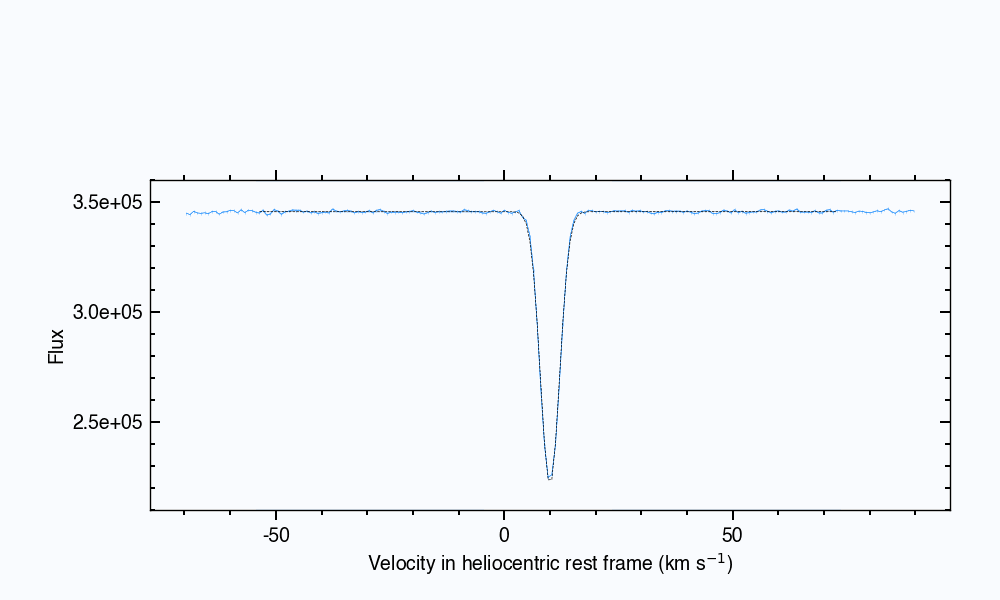

In [25]:
Image(filename = input_nbook['plot_path']+'DI_data/'+input_nbook['par']['instrument']+'_'+input_nbook['par']['night']+'_Indiv/Data/CCF/phase.gif')

**Disk-integrated line properties**

The three plots below show the time-series of RVs, contrast, and FWHM derived from the fits to the disk-integrated CCFs. Transit contacts are shown as dashed black lines, and in-transit exposures are flagged with empty symbols.

Outside of the transit, RVs should trace the Keplerian motion of your star with respect to the solar system barycenter (the Keplerian model defined by your inputs for the star and planets is plotted as a solid blue curve). If your star is quiet and measurements are dominated by white noise, RV measurements should be evenly spread around the Keplerian model, while contrast and FWHM measurements should be evenly spread around their mean out-of-transit value (dashed blue lines). You can assess this by looking at the ratio between the dispersion and mean error over out-of-transit measurements, reported on each plot, which should be close to unity. If that is not the case, you can use the workflow to detrend the data.  

Inside of the transit the planet occults local regions of the stellar surface, distorting the disk-integrated stellar lines and inducing anomalous deviations in their derived properties. Traditionally, measurements of the sky-projected spin-orbit angle in planetary systems have been performed by analyzing this anomalous signal in RV - but the anomaly may not be detectable with faint, slow-rotating stars and small planets. With ANTARESS, you will be able to analyze directly the planet-occulted stellar profiles to get a higher precision on the transit chord and orbital architecture of the system.

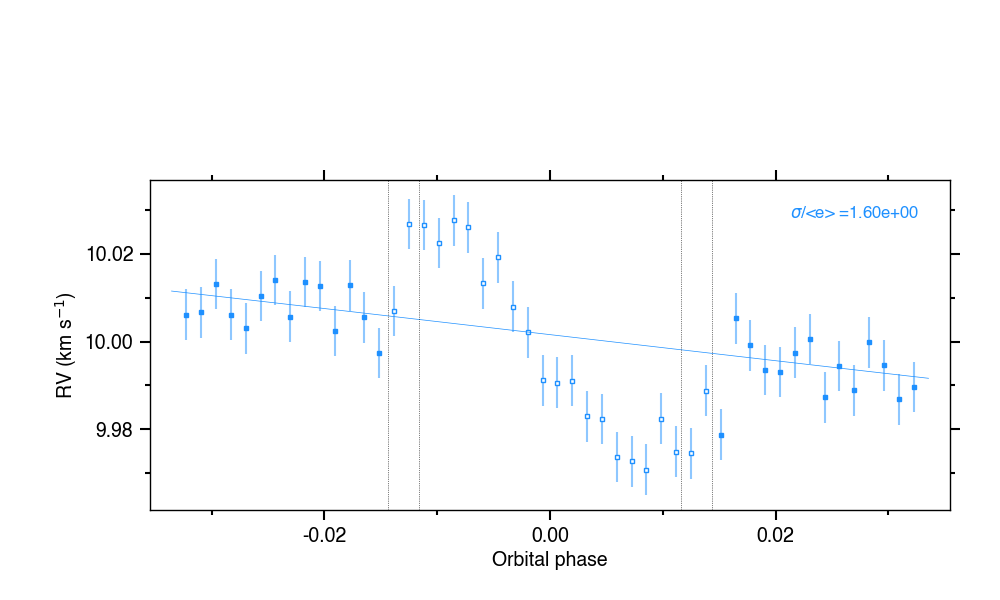

In [26]:
Image(filename = input_nbook['plot_path']+'DI_prop/rv_phase.png')

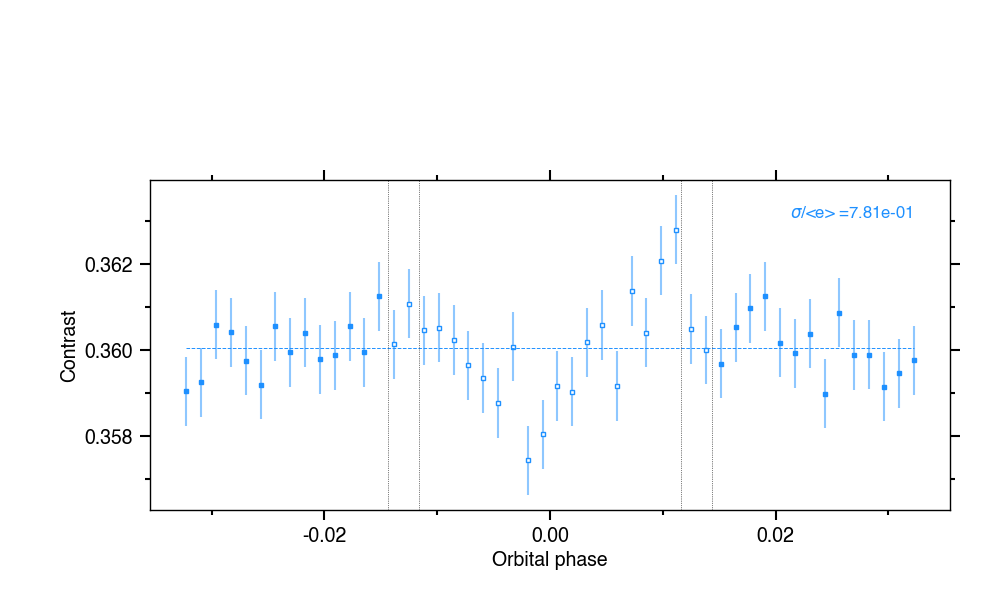

In [27]:
Image(filename = input_nbook['plot_path']+'DI_prop/ctrst_phase.png')

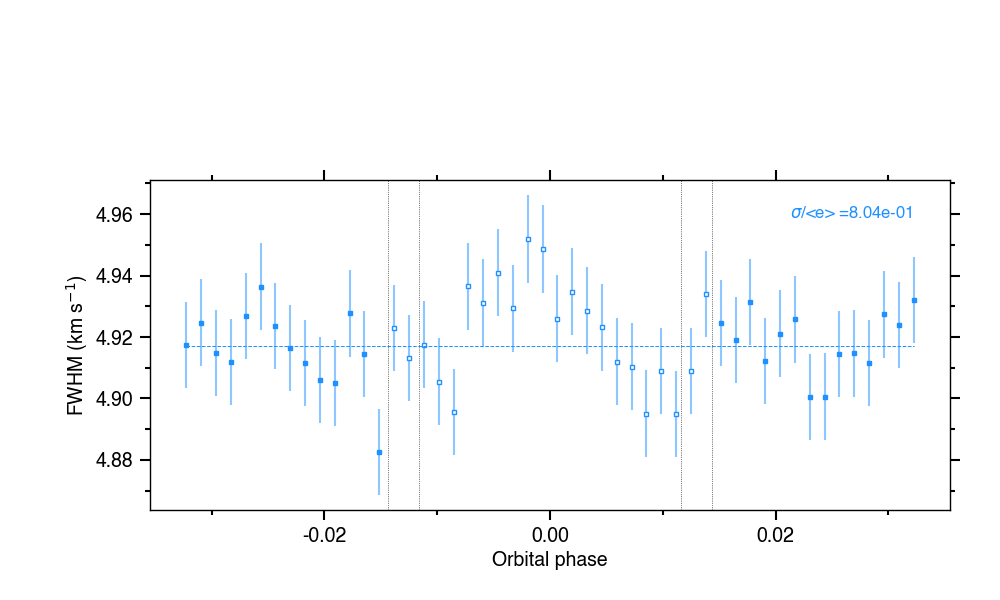

In [28]:
Image(filename = input_nbook['plot_path']+'DI_prop/FWHM_phase.png')

**Intrinsic CCF series**

This plot shows the series of intrinsic CCFs (blue profiles) with their best-fit Gaussian models (dashed black profiles), from which are derived the properties showed in the next plots.

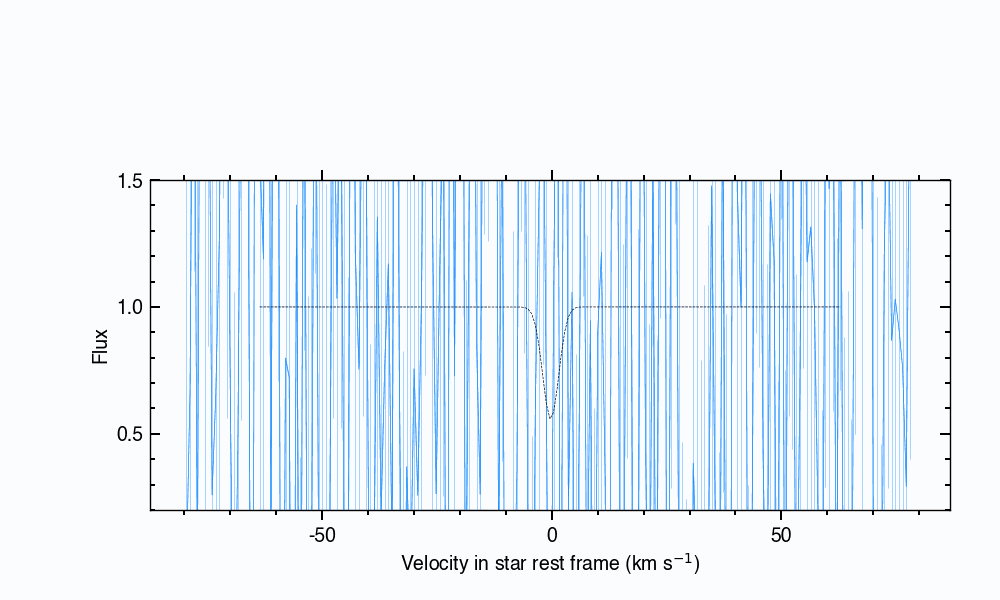

In [29]:
Image(filename = input_nbook['plot_path']+'Intr_data/'+input_nbook['par']['instrument']+'_'+input_nbook['par']['night']+'_Indiv/Data/CCF/phase.gif')

**Intrinsic line properties**

The three plots below show the time-series of RVs, contrast, and FWHM derived from the fits to intrinsic CCFs, which directly trace the properties of the photosphere along the transit chord. Transit contacts are shown as dashed black lines.

The dashed orange lines show the best-fit models you derived for each property series. You can see how the decreasing intensity at the stellar limb, combined with its partial occultation by the planet, leads to intrinsic line properties being derived at a lower precision. For smaller planets and fainter stars all exposures may yield a poor fit individually, making it hazardous to interpret the property time series. Fortunately, useful information can still be retrieved from these exposures by fitting the time series of intrinsic line profiles with a joint model through a RM Revolutions fit. The dashed black lines show the properties associated with this best fit.

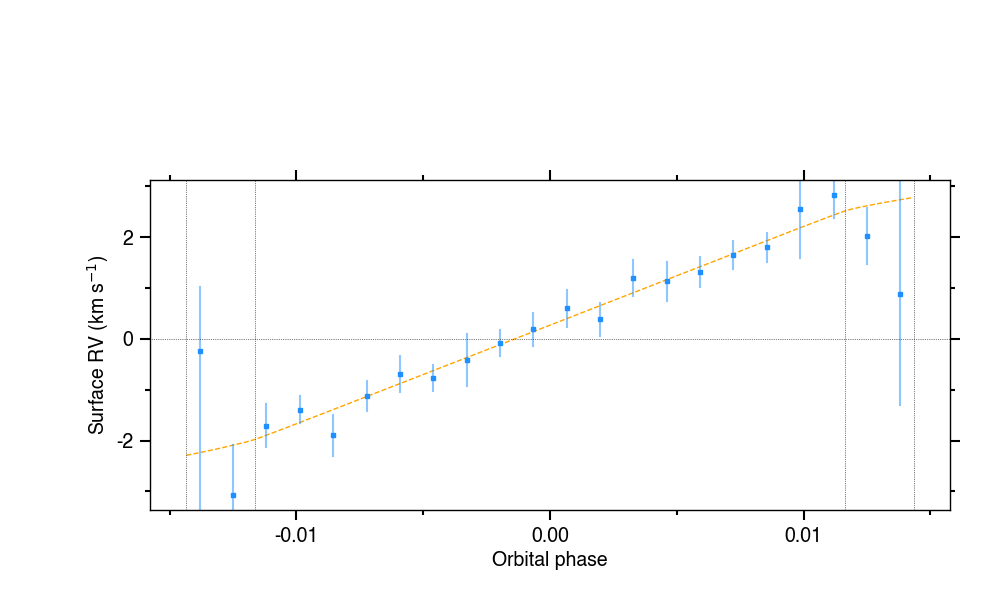

In [30]:
Image(filename = input_nbook['plot_path']+'Intr_prop/rv_phase.png')

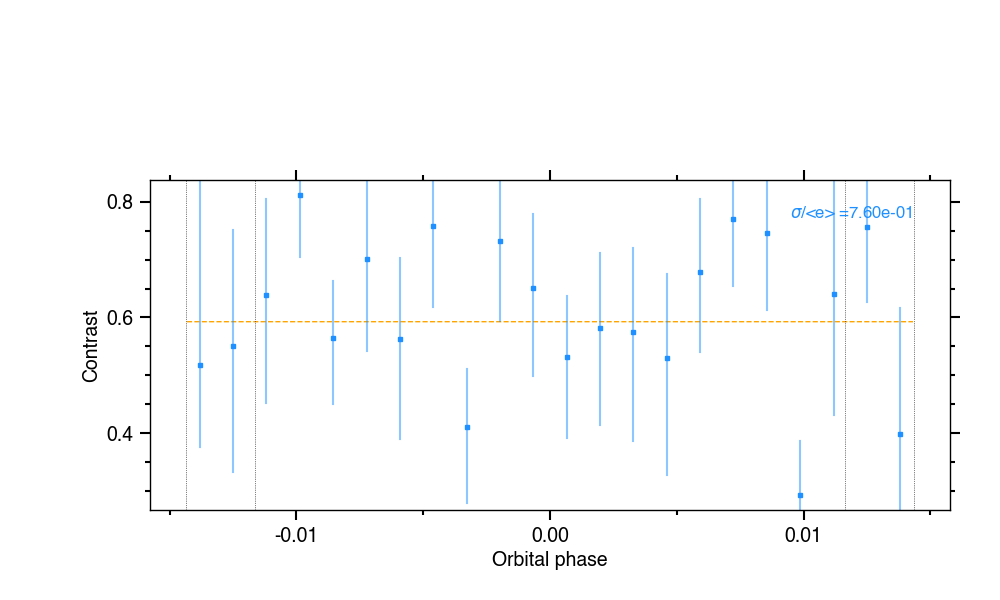

In [31]:
Image(filename = input_nbook['plot_path']+'Intr_prop/ctrst_phase.png')

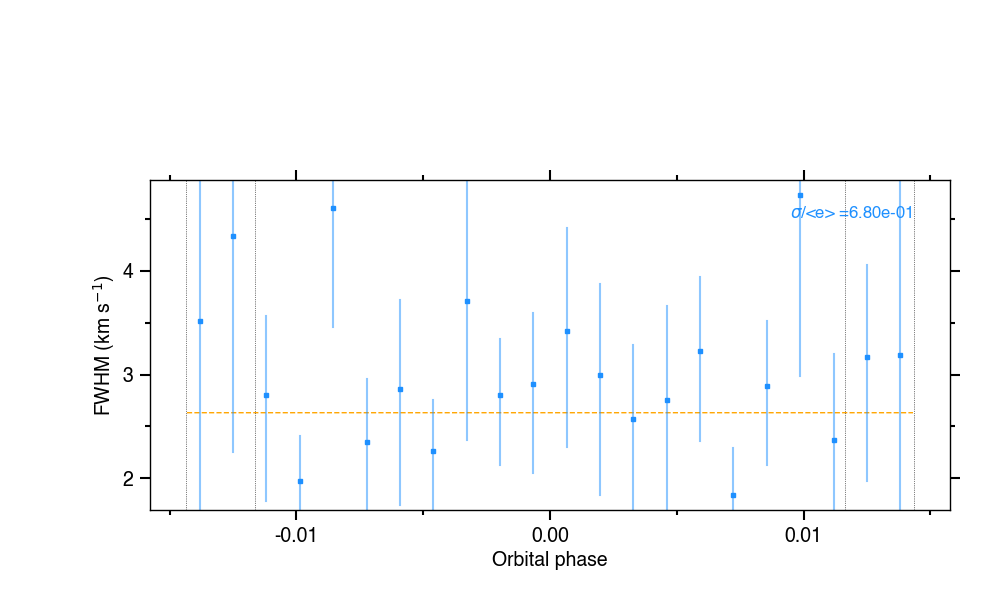

In [32]:
Image(filename = input_nbook['plot_path']+'Intr_prop/FWHM_phase.png')

**Intrinsic line maps**

The first plot shows the series of intrinsic CCFs as a function of RV in the star rest frame and orbital phase, colored with flux. The solid green line traces the centroid of the model stellar lines occulted by the planet, as derived from your best RM Revolutions fit to the full dataset shown in the second plot. The third plot shows the residual values between the processed and model intrinsic CCFs.

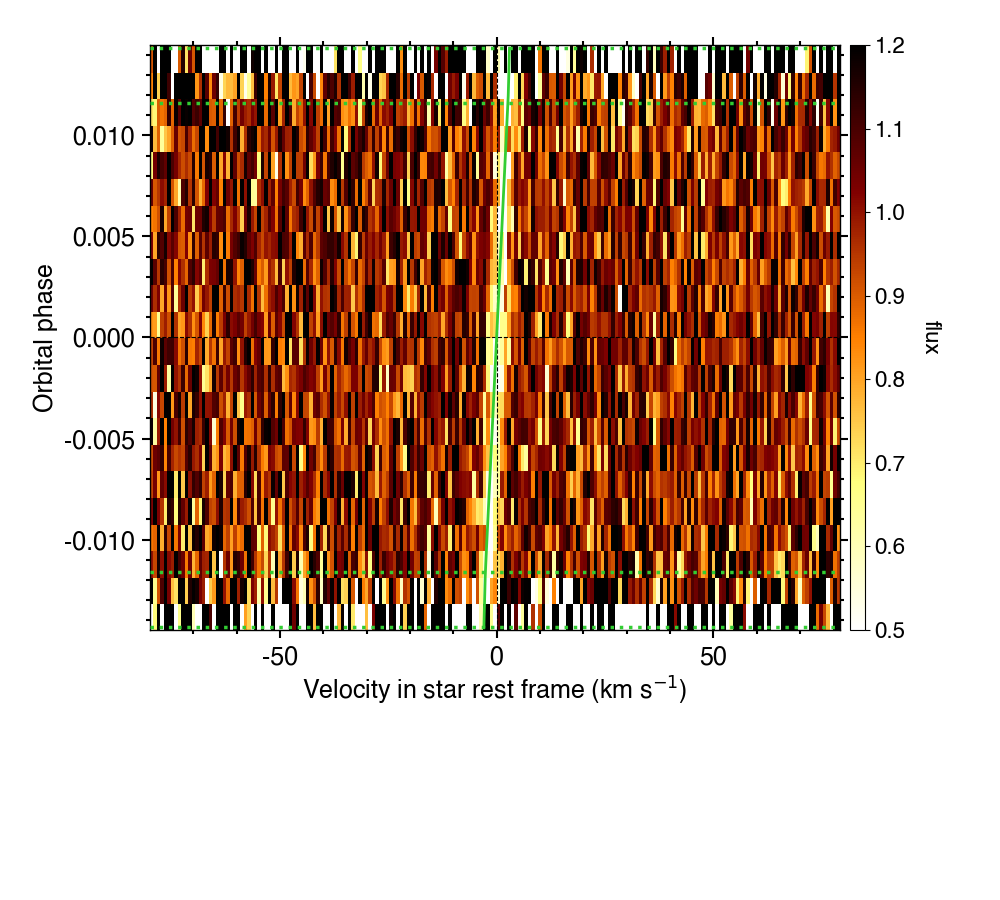

In [33]:
Image(filename = input_nbook['plot_path']+'Intr_data/ESPRESSO_20230624_Map/Data/CCF/iord0.png')

In [34]:
if input_nbook['par']['loc_prof_corr']:Image(filename = input_nbook['plot_path']+'Intr_data/ESPRESSO_20230624_Map/Model/CCF/iord0_glob_mod_rec.png')

In [35]:
if input_nbook['par']['loc_prof_corr']:Image(filename = input_nbook['plot_path']+'Intr_data/ESPRESSO_20230624_Map/Res/CCF/iord0_glob_mod_rec_res.png')

# Results comparison for the example mock dataset

If you ran the successive steps with relevant settings, you should have retrieved best-fit values from the RM Revolutions analysis that match the properties used to generate the mock dataset:
- a projected stellar surface velocity `vsini` = 3 km/s
- a sky-projected spin-orbit angle `lambda` = 35 degrees
- an intrinsic stellar line `contrast` = 0.7
- an intrinsic stellar line `FWHM` = 2.5 km/s 